In [1]:
import io
import sys
import re

import numpy as np 

from bs4 import BeautifulSoup
import requests
import signal
import multiprocessing
import time
from threading import Thread
import func_timeout


import matplotlib.pyplot as plt

import pyscf as scf	

import qiskit as qk
from mpl_toolkits import mplot3d
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q import *
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo
from qiskit_nature.exceptions import QiskitNatureError

%matplotlib widget

/tmp/ipykernel_9721/2122620565.py:28: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import VQE


# H<sub>2</sub> - Clássico - "sto3g" : Polynomial Fit

In [2]:
def groundstate_classico(a, base = "sto3g") :

    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    problem = driver.run()
    result = solver.solve(problem)

    return result.groundenergy + result.nuclear_repulsion_energy

In [3]:

intervalo  = np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))

coeficientes = np.polyfit(intervalo, (gs_energy := list(groundstate_classico(f'{a}') for a in intervalo)), 12)

coeficientes_importante = np.polyfit(intervalo_importante, (gs_energy_importante := gs_energy[:len(intervalo_importante)]), 12)


Text(0, 0.5, 'Erro')

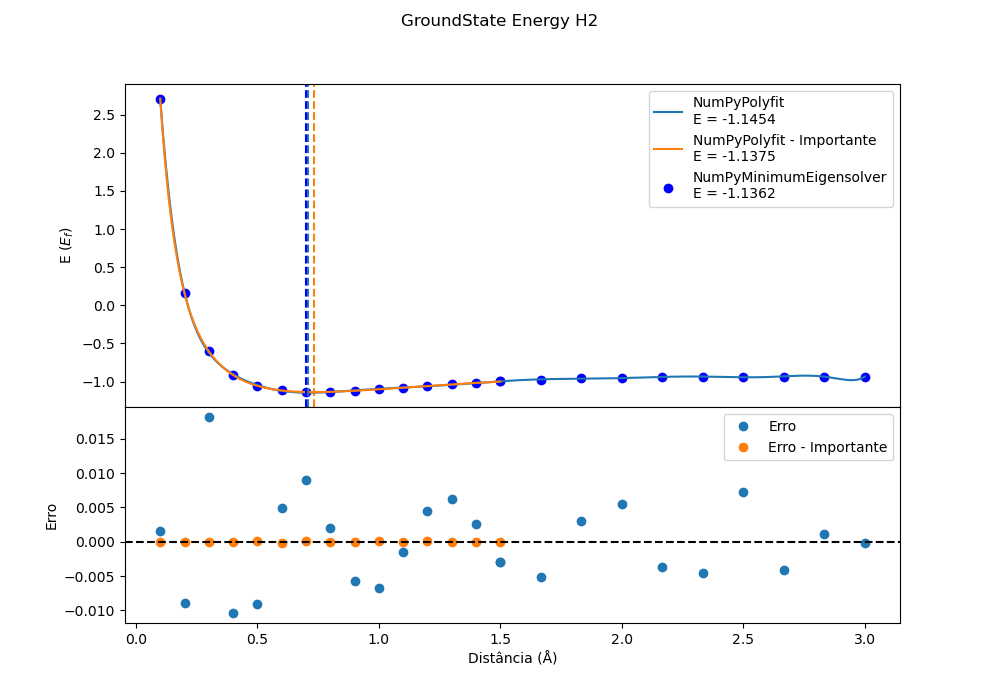

In [4]:

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 7), gridspec_kw={'height_ratios': [3, 2], 'hspace': 0})

ax1.plot((x := np.linspace(min(intervalo), max(intervalo), 500)), (y := np.polyval(coeficientes, x)), label=f'NumPyPolyfit\nE = {(min_y := min(y)):.4f}')
ax1.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(coeficientes_importante, x_importante)), label=f'NumPyPolyfit - Importante\nE = {(min_y_importante := min(y_importante)):.4f}')
ax1.scatter(intervalo, gs_energy, c = 'b', label=f'NumPyMinimumEigensolver\nE = {(min_gs := min(gs_energy)):.4f}')

ax1.axvline(x=x[np.argmin(y)], linestyle='--', color='tab:blue')
ax1.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color='tab:orange')
ax1.axvline(x=intervalo[np.argmin(gs_energy)], linestyle='--', color='b')

ax1.legend()

ax2.plot(intervalo, gs_energy - np.polyval(coeficientes, intervalo), 'o', label='Erro')
ax2.plot(intervalo_importante, gs_energy_importante - np.polyval(coeficientes_importante, intervalo_importante), 'o', label='Erro - Importante')
ax2.axhline(y=0, color='k', linestyle='--')

ax2.legend()

fig.suptitle('GroundState Energy H2')

ax2.set_xlabel('Distância (Å)')
ax1.set_ylabel('E $(E_f)$')
ax2.set_ylabel('Erro')


# H<sub>2</sub> - Clássico - "sto3g" : Comparando Resultados Clássicos

In [13]:


def NPMinimumEigensolver(a, base = "sto3g") :

    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    problem = driver.run()
    result = solver.solve(problem)

    return result.groundenergy + result.nuclear_repulsion_energy


def VariationalQuantumEigensolver(a, base = "sto3g"):
        
    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    
    es_problem = driver.run()
    
    mapper = JordanWignerMapper()

    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        reps=1,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )
        
    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    
    calc = GroundStateEigensolver(mapper, vqe_solver)
    
    res = calc.solve(es_problem)

    return res.groundenergy + res.nuclear_repulsion_energy


def PySCF_HF(a, base = 'sto-3g'):

    mol = scf.M(
        atom = f'H 0 0 0; H 0 0 {a}',
        basis = base
    )

    mol_HF = mol.HF()
    
    sys.stdout = io.StringIO()
    
    a = mol_HF.kernel()
    
    sys.stdout = sys.__stdout__

    return a



def PySCF_KSDFT(a, base = 'sto-3g'):

    mol = scf.M(
        atom = f'H 0 0 0; H 0 0 {a}',
        basis = base
    )

    mol_HF = mol.KS()
    
    sys.stdout = io.StringIO()
    
    mol_HF.xc = 'b3lyp'
     
    a = mol_HF.kernel()
    
    sys.stdout = sys.__stdout__

    return a

 

In [ ]:

intervalo  = np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))

sys.stdout = io.StringIO()

for a in (metodos := ['NPMinimumEigensolver', 'PySCF_HF', 'PySCF_KSDFT', 'VariationalQuantumEigensolver']) :
                
        exec(f"coeficientes_{a} = np.polyfit(intervalo, (gs_energy_{a} := list({a}(str(b)) for b in intervalo)), 12)")

        exec(f"coeficientes_importante_{a} = np.polyfit(intervalo_importante, (gs_energy_importante_{a} := gs_energy_{a}[:len(intervalo_importante)]), 12)")

sys.stdout = sys.__stdout__


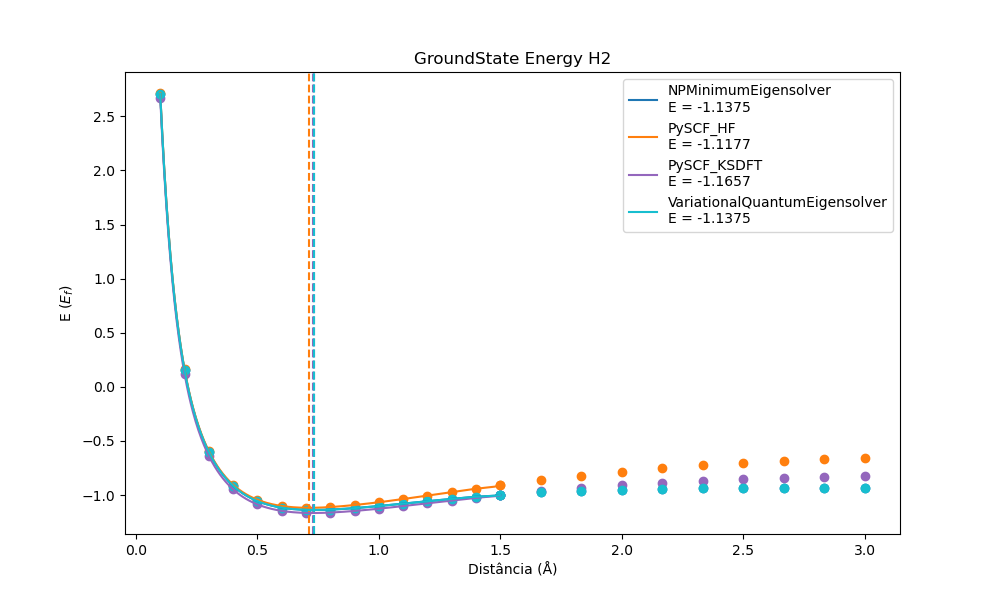

In [15]:

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

groundstate_calculados = []

for a,b in zip(metodos, ['tab:blue','tab:orange','tab:purple', 'tab:cyan']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coeficientes_importante_{a}"), x_importante)), label=f'{a}\nE = {(min_y_importante := min(y_importante)):.4f}', color = b)
    ax.scatter(intervalo, eval(f"gs_energy_{a}"), color = b)

    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    
    groundstate_calculados.append([a, min_y_importante])

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()


In [16]:
groundstate_calculados

[['NPMinimumEigensolver', -1.1374509716890682],
 ['PySCF_HF', -1.1176602240094269],
 ['PySCF_KSDFT', -1.1656868295199665],
 ['VariationalQuantumEigensolver', -1.1374509780295767]]

In [17]:
f"{groundstate_calculados[0][0]} - {groundstate_calculados[-1][0]} : {abs(groundstate_calculados[0][1] - groundstate_calculados[-1][1])}"

'NPMinimumEigensolver - VariationalQuantumEigensolver : 6.340508562630021e-09'

# H<sub>2</sub> - Quantum - "sto3g" : Comparando VQEs, Estimator vs AER (Noise)

In [18]:

def VQE_Estimator_Exact(a, base = "sto3g"):
        
    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    
    es_problem = driver.run()
    
    mapper = JordanWignerMapper()

    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    
    calc = GroundStateEigensolver(mapper, vqe_solver)
    
    res = calc.solve(es_problem)

    return res.groundenergy + res.nuclear_repulsion_energy



def VQE_Estimator_Shots_Seeds(a, base = "sto3g", shots = 2048, seed = 42):
        
    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    
    es_problem = driver.run()
    
    mapper = JordanWignerMapper()

    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(Estimator(options={"shots": shots, "seed": seed}), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    
    calc = GroundStateEigensolver(mapper, vqe_solver)
    
    res = calc.solve(es_problem)

    return res.groundenergy + res.nuclear_repulsion_energy



def VQE_AerEstimator_Exact_NoNoise(a, base = "sto3g"):
        
    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    
    es_problem = driver.run()
    
    mapper = JordanWignerMapper()

    estimator_ = AerEstimator(
        run_options={"shots": None},
        approximation=True,
    )
    
    
    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(estimator_, ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    
    calc = GroundStateEigensolver(mapper, vqe_solver)
    
    res = calc.solve(es_problem)
    
    return res.groundenergy + res.nuclear_repulsion_energy



def VQE_AerEstimator_Noise(a, base = "sto3g", shots = 2048*10, seed = 42, method = "density_matrix"):
        
    driver = PySCFDriver(
        atom= f"H 0 0 0; H 0 0 {a}",
        basis=base,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    
    es_problem = driver.run()
    
    mapper = JordanWignerMapper()

    device = FakeVigo()

    coupling_map = device.configuration().coupling_map
    noise_model = NoiseModel.from_backend(device)

    estimator_ = AerEstimator(
        backend_options={
        "method": method,
        "coupling_map": coupling_map,
        "noise_model": noise_model,
        },
        run_options={"seed": seed, "shots": shots},
        transpile_options={"seed_transpiler": seed},
    )
    
    
    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(estimator_, ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    
    calc = GroundStateEigensolver(mapper, vqe_solver)
    
    res = calc.solve(es_problem)
    
    return res.groundenergy + res.nuclear_repulsion_energy


In [19]:
display(VQE_Estimator_Exact(1))
display(VQE_Estimator_Shots_Seeds(1))
display(VQE_AerEstimator_Exact_NoNoise(1))
display(VQE_AerEstimator_Noise(1, shots = 2048*10, seed = 200))

-1.1011503188064728

-1.1011498581202321

-1.1011503188064906

-0.8264172289788226

In [20]:
display(VQE_Estimator_Shots_Seeds(1))
display(VQE_Estimator_Shots_Seeds(1, seed=1))
display(VQE_Estimator_Shots_Seeds(1, seed=201))

-1.1011498581202321

-1.1011503089906096

-1.101149131047984

In [21]:
display(VQE_AerEstimator_Noise(1, shots = 2048*10, seed = 200))
display(VQE_AerEstimator_Noise(1, shots = 2048*10, seed = 200, method='statevector'))

-0.8264172289788226

-0.8317038459458254

In [22]:
intervalo  = np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))

sys.stdout = io.StringIO()

for a in (metodos := ['VQE_Estimator_Exact', 'VQE_Estimator_Shots_Seeds', 'VQE_AerEstimator_Exact_NoNoise', 'VQE_AerEstimator_Noise']) :
                
        exec(f"coeficientes_{a} = np.polyfit(intervalo, (gs_energy_{a} := list({a}(str(b)) for b in intervalo)), 12)")

        exec(f"coeficientes_importante_{a} = np.polyfit(intervalo_importante, (gs_energy_importante_{a} := gs_energy_{a}[:len(intervalo_importante)]), 12)")

sys.stdout = sys.__stdout__

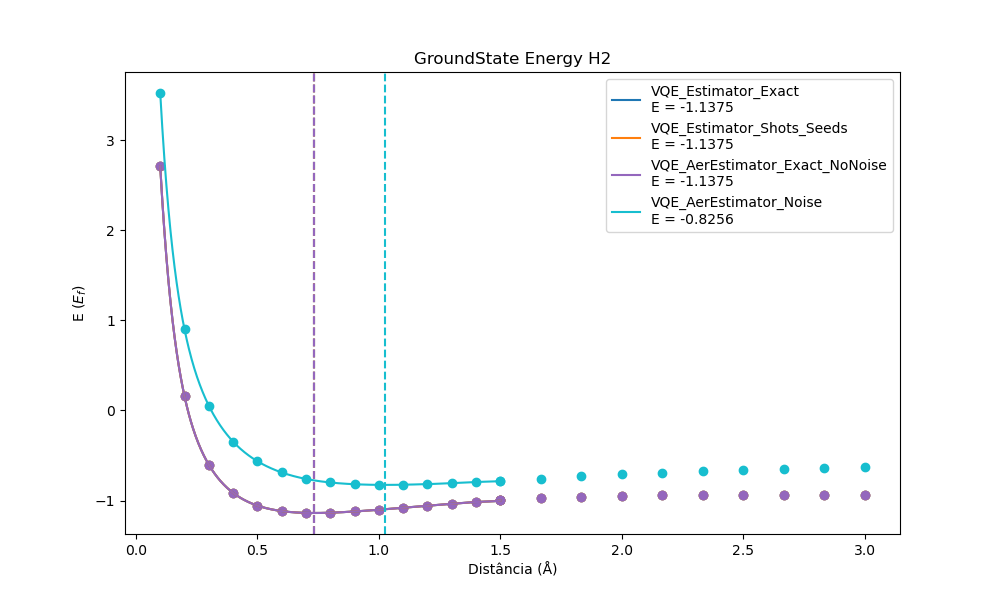

In [23]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

groundstate_calculados = []

for a,b in zip(metodos, ['tab:blue','tab:orange','tab:purple', 'tab:cyan']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coeficientes_importante_{a}"), x_importante)), label=f'{a}\nE = {(min_y_importante := min(y_importante)):.4f}', color = b)
    ax.scatter(intervalo, eval(f"gs_energy_{a}"), color = b)

    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    
    groundstate_calculados.append([a, min_y_importante])

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

In [24]:
intervalo_importante = np.linspace(0.5, 1, 15)

for a in (metodos := ['VQE_Estimator_Exact', 'VQE_Estimator_Shots_Seeds', 'VQE_AerEstimator_Exact_NoNoise']) :

        exec(f"coeficientes_importante_{a} = np.polyfit(intervalo_importante, (gs_energy_importante_{a} := list({a}(str(b)) for b in intervalo_importante)), 12)")


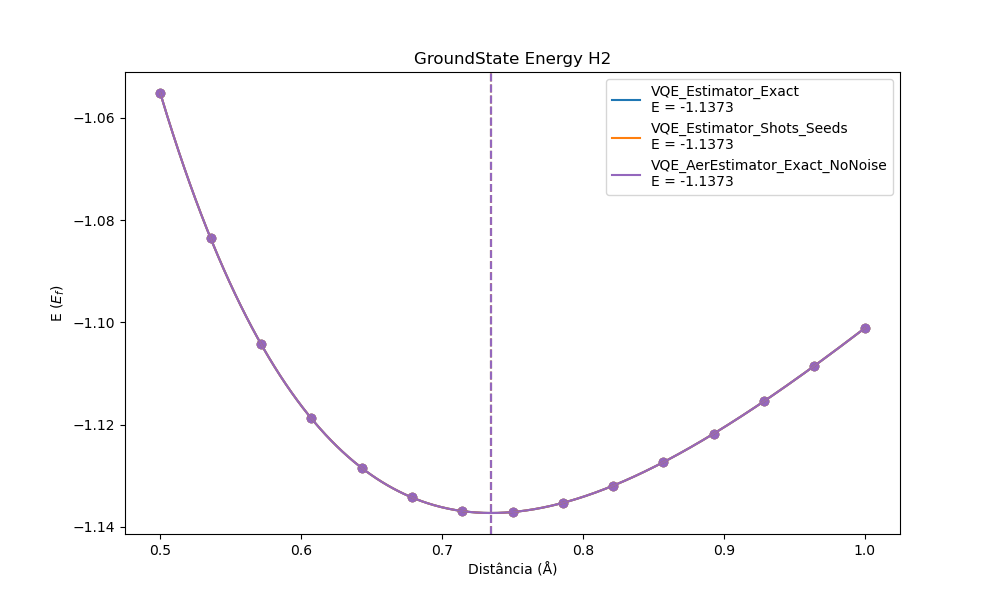

In [25]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

groundstate_calculados = []

for a,b in zip(metodos, ['tab:blue','tab:orange','tab:purple']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coeficientes_importante_{a}"), x_importante)), label=f'{a}\nE = {(min_y_importante := min(y_importante)):.4f}', color = b)
    ax.scatter(intervalo_importante, eval(f"gs_energy_importante_{a}"), color = b)

    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    
    groundstate_calculados.append([a, min_y_importante])

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

In [26]:
intervalo  = np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))

for a in (metodos := range(1000, 10000, 1000)):
                
        exec(f"coeficientes_{a} = np.polyfit(intervalo, (gs_energy_{a} := list(VQE_AerEstimator_Noise(str(b), shots = {a}) for b in intervalo)), 12)")

        exec(f"coeficientes_importante_{a} = np.polyfit(intervalo_importante, (gs_energy_importante_{a} := gs_energy_{a}[:len(intervalo_importante)]), 12)")

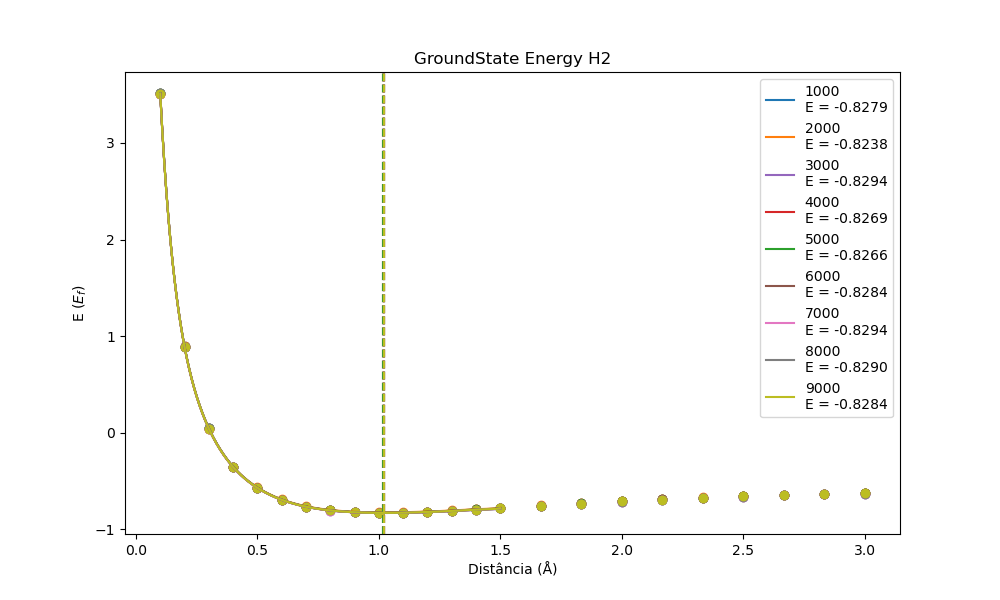

In [27]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

groundstate_calculados = []

for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coeficientes_importante_{a}"), x_importante)), label=f'{a}\nE = {(min_y_importante := min(y_importante)):.4f}', color = b)
    ax.scatter(intervalo, eval(f"gs_energy_{a}"), color = b)

    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    
    groundstate_calculados.append([a, min_y_importante])

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

In [28]:
intervalo  = np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))

metodos = ['statevector', 'density_matrix']
                
coeficientes_statevector = np.polyfit(intervalo, (gs_energy_statevector := list(VQE_AerEstimator_Noise(str(b), method = 'statevector') for b in intervalo)), 12)

coeficientes_importante_statevector = np.polyfit(intervalo_importante, (gs_energy_importante_statevector := gs_energy_statevector[:len(intervalo_importante)]), 12)
                
coeficientes_density_matrix = np.polyfit(intervalo, (gs_energy_density_matrix := list(VQE_AerEstimator_Noise(str(b), method = 'density_matrix') for b in intervalo)), 12)

coeficientes_importante_density_matrix = np.polyfit(intervalo_importante, (gs_energy_importante_density_matrix := gs_energy_density_matrix[:len(intervalo_importante)]), 12)

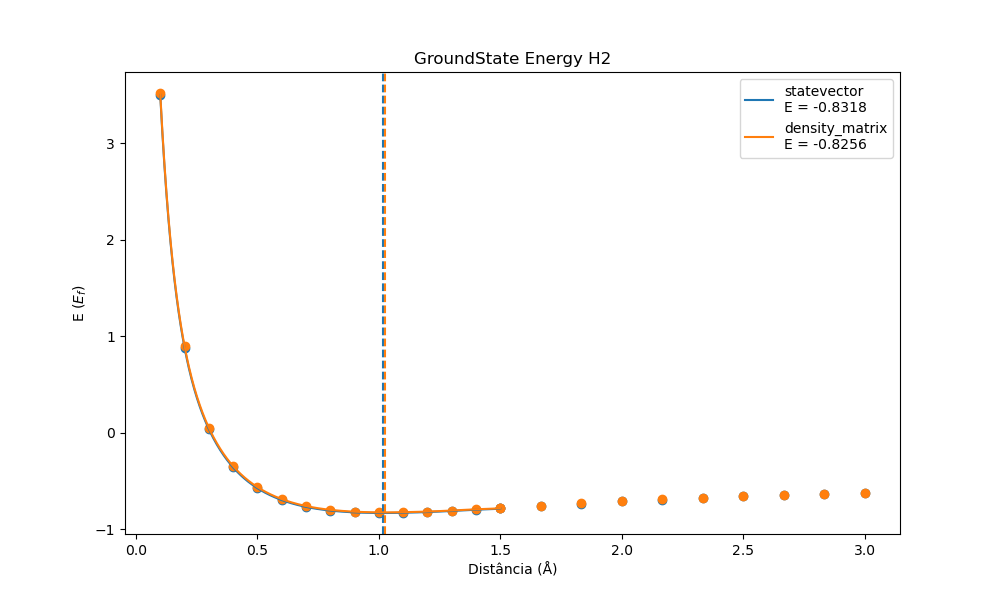

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

groundstate_calculados = []

for a,b in zip(metodos, ['tab:blue', 'tab:orange']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coeficientes_importante_{a}"), x_importante)), label=f'{a}\nE = {(min_y_importante := min(y_importante)):.4f}', color = b)
    ax.scatter(intervalo, eval(f"gs_energy_{a}"), color = b)

    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    
    groundstate_calculados.append([a, min_y_importante])

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()

# H<sub>2</sub> - Clássico : Comparando Bases

In [3]:
url = 'https://www.basissetexchange.org/'

result = requests.get(url)

doc = BeautifulSoup(result.content, 'html.parser')

tags = doc.find(id="basis_sets")

tags2 = tags.find_all('option')

bases = list(a.string for a in tags2)

In [5]:
bases

['2ZaPa-NR',
 '2ZaPa-NR-CV',
 '3-21G',
 '3ZaPa-NR',
 '3ZaPa-NR-CV',
 '4-31G',
 '4ZaPa-NR',
 '4ZaPa-NR-CV',
 '5-21G',
 '5ZaPa-NR',
 '5ZaPa-NR-CV',
 '6-21G',
 '6-31++G',
 '6-31++G*',
 '6-31++G**',
 '6-31++G**-J',
 '6-31+G',
 '6-31+G*',
 '6-31+G*-J',
 '6-31+G**',
 '6-311++G',
 '6-311++G(2d,2p)',
 '6-311++G(3df,3pd)',
 '6-311++G*',
 '6-311++G**',
 '6-311++G**-J',
 '6-311+G',
 '6-311+G(2d,p)',
 '6-311+G*',
 '6-311+G*-J',
 '6-311+G**',
 '6-311G',
 '6-311G(2df,2pd)',
 '6-311G(d,p)',
 '6-311G-J',
 '6-311G*',
 '6-311G**',
 '6-311G**-RIFIT',
 '6-311xxG(d,p)',
 '6-31G',
 '6-31G(2df,p)',
 '6-31G(3df,3pd)',
 '6-31G(d,p)',
 '6-31G-Blaudeau',
 '6-31G-J',
 '6-31G*',
 '6-31G*-Blaudeau',
 '6-31G**',
 '6-31G**-RIFIT',
 '6ZaPa-NR',
 '7ZaPa-NR',
 'acv2z-J',
 'acv3z-J',
 'acv4z-J',
 'admm-1',
 'admm-2',
 'admm-3',
 'AHGBS-5',
 'AHGBS-7',
 'AHGBS-9',
 'AHGBSP1-5',
 'AHGBSP1-7',
 'AHGBSP1-9',
 'AHGBSP2-5',
 'AHGBSP2-7',
 'AHGBSP2-9',
 'AHGBSP3-5',
 'AHGBSP3-7',
 'AHGBSP3-9',
 'Ahlrichs pVDZ',
 'Ahlrichs TZV',

In [6]:
bases2_ = []

for a in bases[:]:

    try:
        
        bases2_.append([a, func_timeout.func_timeout(1, NPMinimumEigensolver, args=('0.735', a))])
        display(a)

    finally:
            
        continue

/home/gabriel/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


'3-21G'

'4-31G'

'6-31+G'

'6-31+G*'

'6-31G'

'6-31G*'

'LANL2DZ'

'pc-0'

'pcseg-0'

'STO-3G'

'STO-6G'

In [11]:
list(a[0] for a in bases2_)

['3-21G',
 '4-31G',
 '6-31+G',
 '6-31+G*',
 '6-31G',
 '6-31G*',
 'LANL2DZ',
 'pc-0',
 'pcseg-0',
 'STO-3G',
 'STO-6G']

In [ ]:
for b in list(a[0] for a in bases2_):
    
    display(re.sub(r'\W+', '', b))

In [4]:
bases2_ = [['3-21G', -1.1477292427955987],
 ['4-31G', -1.1516143184174887],
 ['6-31+G', -1.151614319937249],
 ['6-31+G*', -1.151614319937253],
 ['6-31G', -1.1516143199372508],
 ['6-31G*', -1.1516143199372442],
 ['LANL2DZ', -1.1514235511375124],
 ['pc-0', -1.145119257996451],
 ['pcseg-0', -1.1451189202532284],
 ['STO-3G', -1.137306035753395],
 ['STO-6G', -1.1459778538543919]]

In [6]:
intervalo = np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))

nome = {}

for b in [c[0] for c in bases2_]:
     
     if (strip := re.sub(r'\W+', '', b)) not in nome.values():
            
          nome[b] = strip
     
     else:
          
          nome[b] = strip + '1'

for a in (metodos := nome.keys()) :
                
        exec(f"coeficientes_{nome[a]} = np.polyfit(intervalo, (gs_energy_{nome[a]} := list(NPMinimumEigensolver(str(b), '{a}') for b in intervalo)), 12)")

        exec(f"coeficientes_importante_{nome[a]} = np.polyfit(intervalo_importante, (gs_energy_importante_{nome[a]} := gs_energy_{nome[a]}[:len(intervalo_importante)]), 12)")

/home/gabriel/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


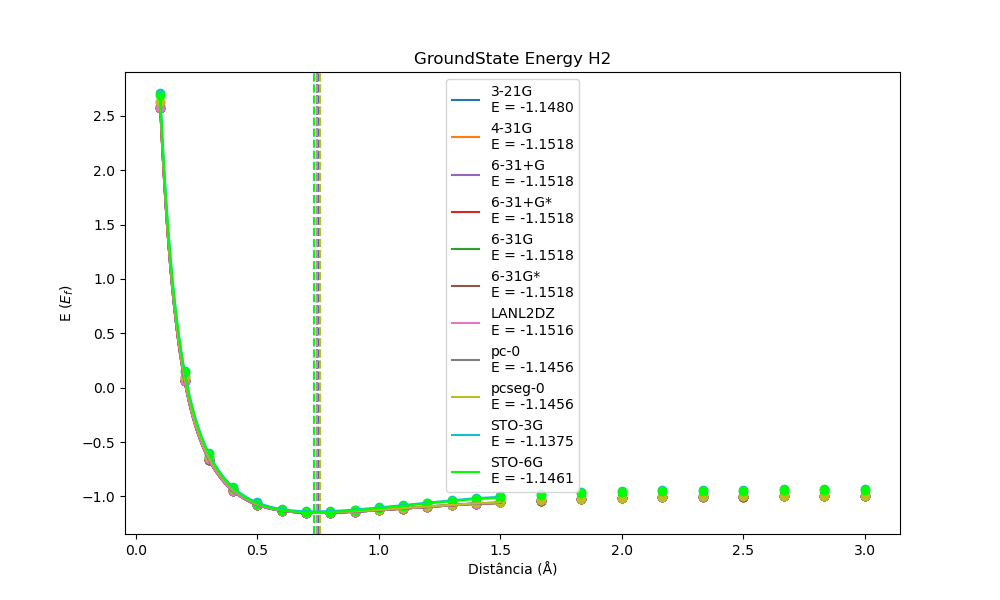

In [9]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

groundstate_calculados = []

for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):
    
    ax.plot((x_importante := np.linspace(min(intervalo_importante), max(intervalo_importante), 500)), (y_importante := np.polyval(eval(f"coeficientes_importante_{nome[a]}"), x_importante)), label=f'{a}\nE = {(min_y_importante := min(y_importante)):.4f}', color = b)
    ax.scatter(intervalo, eval(f"gs_energy_{nome[a]}"), color = b)

    ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)
    
    groundstate_calculados.append([a, min_y_importante])

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(E_f)$')

ax.set_title('GroundState Energy H2')

ax.legend()